In [1]:
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
plt.style.use("ggplot")
pd.set_option('display.max_colwidth', None)

In [2]:
dataset = pd.read_csv("Data/citations/fakequote.csv", na_values=['\r\n', ' '])
print(f"Dataset puro tem {dataset.shape[0]} linhas")
dataset.dropna(inplace=True)
print(f"Dataset sem NaNs tem {dataset.shape[0]} linhas")
dataset.head()

Dataset puro tem 1463 linhas
Dataset sem NaNs tem 1336 linhas


,title,citation,category,url
1,"Ao atacar vacina chinesa, Bolsonaro distorce fatos e cita informação falsa",Não se justifica um bilionário aporte financeiro num medicamento que sequer ultrapassou sua fase de testagem.,CONTRADITÓRIO,https://www.aosfatos.org/noticias/ao-atacar-vacina-chinesa-bolsonaro-distorce-fatos-e-cita-informacao-falsa/
2,"Ao atacar vacina chinesa, Bolsonaro distorce fatos e cita informação falsa","A questão de vacinação ou não é uma lei de 75 que é bem clara que o Programa Nacional de Imunização, aí incluída as vacinas obrigatórias, compete ao Ministro da Saúde.",EXAGERADO,https://www.aosfatos.org/noticias/ao-atacar-vacina-chinesa-bolsonaro-distorce-fatos-e-cita-informacao-falsa/
3,"Ao atacar vacina chinesa, Bolsonaro distorce fatos e cita informação falsa","Inclusive tem um vídeo, do senhor João Doria, de poucos dias, onde ele diz claramente que obrigaria os aproximadamente 40 milhões habitantes do estado de São Paulo a se vacinarem.",VERDADEIRO,https://www.aosfatos.org/noticias/ao-atacar-vacina-chinesa-bolsonaro-distorce-fatos-e-cita-informacao-falsa/
4,"Ao atacar vacina chinesa, Bolsonaro distorce fatos e cita informação falsa",Hoje em dia pelo menos metade da população diz que não quer tomar essa vacina [CoronaVac],VERDADEIRO,https://www.aosfatos.org/noticias/ao-atacar-vacina-chinesa-bolsonaro-distorce-fatos-e-cita-informacao-falsa/
13,"Na reta final, candidatos em São Paulo derrapam ao falar de pandemia, habitação e creches",As crianças ficaram quatro meses sem receber o voucher de alimentação [durante a pandemia]. –,IMPRECISO,https://www.aosfatos.org/noticias/na-reta-final-candidatos-em-sao-paulo-derrapam-ao-falar-de-pandemia-habitacao-e-creches/


## Distribuição das categorias

<AxesSubplot:xlabel='count', ylabel='category'>

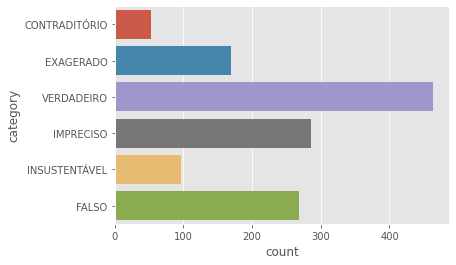

In [3]:
sns.countplot(y='category', data=dataset)

In [4]:
dataset['length'] = dataset['citation'].apply(len)

<AxesSubplot:xlabel='category', ylabel='length'>

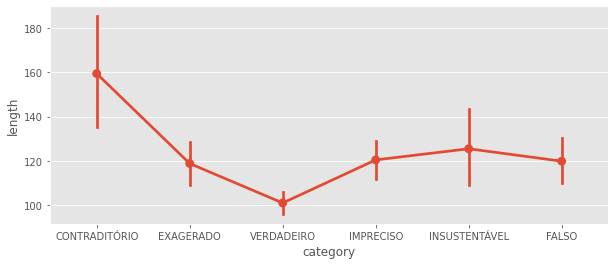

In [5]:
plt.figure(figsize=(10,4))
sns.pointplot(x='category', y='length', data=dataset)

## Pré processamento

In [6]:
nlp = spacy.load("pt_core_news_lg", disable=["parser"])

In [7]:
def pre_process_text(nlp_doc):
    pre_processed = []
    for token in nlp_doc:
        if token.is_stop:
            continue
        if not(token.is_alpha):
            continue
        pre_processed.append(str(token.lemma_))
    return pre_processed

In [8]:
docs = nlp.pipe(list(dataset['citation']))

In [9]:
dataset['pre_processed'] = [pre_process_text(d) for d in docs]

## Freqplots

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=50)
corpus = [' '.join(d) for d in list(dataset['pre_processed'])]
X = vectorizer.fit_transform(corpus)

In [12]:
freq_df = pd.DataFrame(list(X.toarray()), columns=vectorizer.get_feature_names()) 
freq_df['category'] = dataset['category']

In [13]:
freqs_gb = freq_df.groupby(by='category').sum()
freqs_gb.loc['TOTAL'] = list(freq_df.sum().values)
freqs_gb = freqs_gb.T
freqs_gb.sort_values(by='TOTAL', ascending=False, inplace=True)

In [14]:
freqs_gb.head(15)

category,CONTRADITÓRIO,EXAGERADO,FALSO,IMPRECISO,INSUSTENTÁVEL,VERDADEIRO,TOTAL
ano,1,19,52,38,16,72,222
brasil,8,12,25,26,8,43,128
milhão,2,14,20,19,2,39,103
governar,1,9,15,13,4,39,90
paulo,0,6,13,20,7,33,89
pt,0,10,11,11,3,26,75
bilião,1,6,7,17,11,24,74
hoje,4,7,14,15,4,23,72
ter,3,7,14,15,1,26,72
país,1,9,13,19,2,24,70


### Contagem

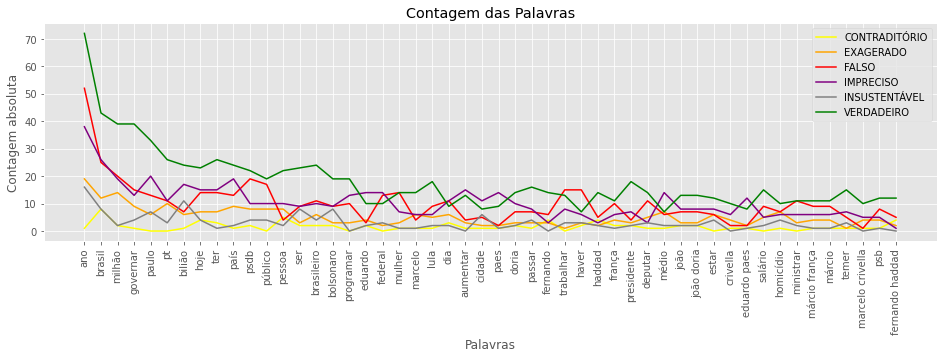

In [15]:
fig, ax = plt.subplots(figsize=(16,4))
for col,color in zip(freqs_gb.columns[:6], ['yellow', 'orange', 'red', 'purple', 'gray', 'green']):
    ax.plot(freqs_gb.index, freqs_gb[col], label=col, color=color)
ax.set_title("Contagem das Palavras")
ax.set_xlabel("Palavras")
ax.set_ylabel("Contagem absoluta")
plt.legend()
plt.xticks(rotation=90)
plt.show()

### Frequência relativa

In [16]:
freqs_rel_gb = pd.DataFrame()
denominador = freqs_gb.sum().values
for col,i in zip(freqs_gb.columns[:6], range(6)):
    freqs_rel_gb[col] = freqs_gb[col]/denominador[i]

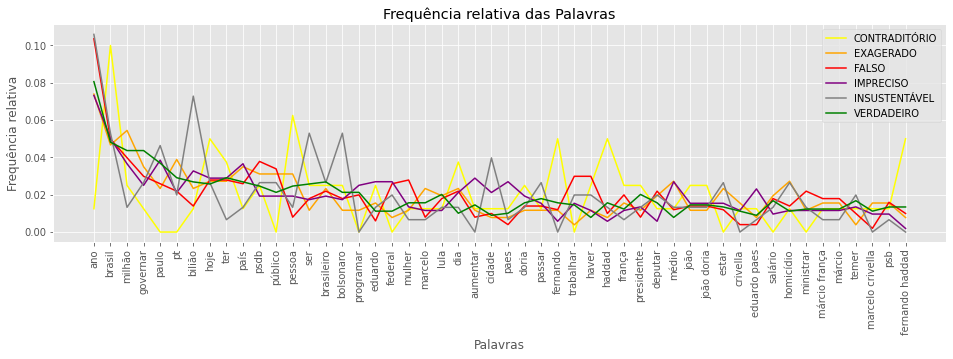

In [17]:
fig, ax = plt.subplots(figsize=(16,4))
for col, color in zip(freqs_rel_gb.columns[:6], ['yellow', 'orange', 'red', 'purple', 'gray', 'green']):
    ax.plot(freqs_rel_gb.index, freqs_rel_gb[col], label=col, color=color)
ax.set_title("Frequência relativa das Palavras")
ax.set_xlabel("Palavras")
ax.set_ylabel("Frequência relativa")
plt.legend()
plt.xticks(rotation=90)
plt.show()

#### Apenas falso e verdadeiro

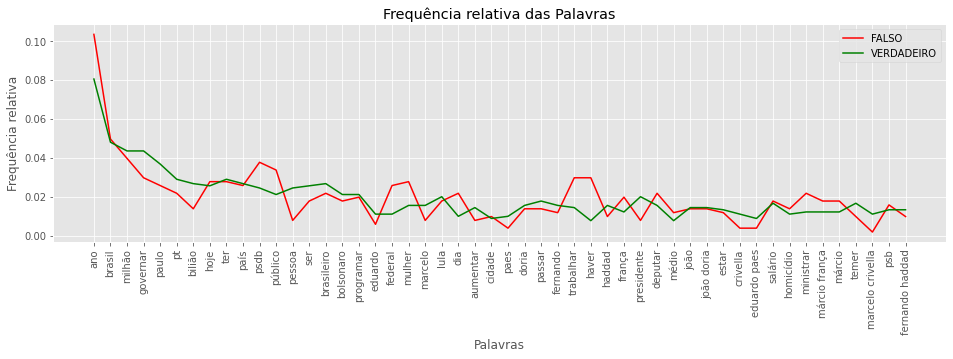

In [18]:
fig, ax = plt.subplots(figsize=(16,4))
for col, color in zip(['FALSO', 'VERDADEIRO'], ['red', 'green']):
    ax.plot(freqs_rel_gb.index, freqs_rel_gb[col], label=col, color=color)
ax.set_title("Frequência relativa das Palavras")
ax.set_xlabel("Palavras")
ax.set_ylabel("Frequência relativa")
plt.legend()
plt.xticks(rotation=90)
plt.show()